# INSTALL

In [ ]:
import os, textwrap



In [22]:
# Write config so shell rclone commands work immediately
conf_dir = os.path.expanduser("~/.config/rclone")
os.makedirs(conf_dir, exist_ok=True)
conf_path = os.path.join(conf_dir, "rclone.conf")
with open(conf_path, "w", encoding="utf-8") as fh:
    fh.write(rclone_conf + "\n")
os.environ["RCLONE_CONFIG"] = conf_path
print(f"Rclone config written to {conf_path}")


Rclone config written to /root/.config/rclone/rclone.conf


In [23]:
# -*- coding: utf-8 -*-
# --- Setup: NanoBanana Pro deps ---

!pip install fal-client requests
!pip -q install --upgrade pip
!pip install "google-genai>=1.40.0" pillow numpy opencv-python-headless matplotlib piexif tqdm

import os, shutil, tempfile, zipfile, urllib.request, subprocess

def ensure_rclone():
    existing = shutil.which("rclone")
    if existing:
        return existing
    url = "https://downloads.rclone.org/rclone-current-linux-amd64.zip"
    try:
        with tempfile.TemporaryDirectory() as tmp:
            zip_path = os.path.join(tmp, "rclone.zip")
            urllib.request.urlretrieve(url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(tmp)
            folder = next((d for d in os.listdir(tmp) if d.startswith("rclone") and os.path.isdir(os.path.join(tmp, d))), None)
            if not folder:
                return None
            src = os.path.join(tmp, folder, "rclone")
            dest = "/usr/local/bin/rclone"
            shutil.copy2(src, dest)
            os.chmod(dest, 0o755)
            return dest
    except Exception as err:
        print(f"⚠️ Unable to install rclone automatically: {err}")
        return None

rc_path = ensure_rclone()
if rc_path:
    os.environ["PATH"] = "/usr/local/bin:" + os.environ.get("PATH", "")
    try:
        ver = subprocess.check_output([rc_path, "version"], text=True).strip().splitlines()[0]
    except Exception:
        ver = "installed"
    print(f"✅ rclone ready at {rc_path} ({ver})")
else:
    print("⚠️ rclone not installed; uploads will stay local.")

print("✅ Setup done for NanoBanana Pro.")


✅ rclone ready at /usr/local/bin/rclone (rclone v1.72.0)
✅ Setup done for NanoBanana Pro.


In [24]:
import os, re, fnmatch, math
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageChops, ImageFilter, ImageDraw, ImageFont


# Select angles

In [25]:
fr_lft = True #@param {type:"boolean"}
fr_rght = True #@param {type:"boolean"}
fr_cl = True #@param {type:"boolean"}
bc_lft = True #@param {type:"boolean"}
bc_rght = True #@param {type:"boolean"}
lft = True #@param {type:"boolean"}
rght = True #@param {type:"boolean"}
bc_ = True #@param {type:"boolean"}
fr_ = True #@param {type:"boolean"}
fr_cl_btm = False #@param {type:"boolean"}
fr_cl_tp = False #@param {type:"boolean"}


names = ["fr_lft","fr_rght","fr_cl","bc_lft","bc_rght","lft","rght","bc_","fr_","fr_cl_btm","fr_cl_tp"]
ALLOWED_BASES = [n for n in names if locals()[n]]

# CONFIG

In [26]:
import os, re
# --- Unified CONFIG ---
FAL_KEY = os.getenv("FAL_KEY")
try:
    from google.colab import userdata
    FAL_KEY = FAL_KEY or userdata.get("FAL_KEY")
except Exception:
    pass

# SKU list to process
SKU_CSV = "29007"  #@param {type:"string"}

# Paths
BASE_PHOTOS_ROOT  = "/content/drive/MyDrive/Dazzl/SikSilk/SKSLK_MODELS/"
GARMENTS_ROOT     = "/content/drive/MyDrive/Dazzl/SikSilk/AlexGens/SikSilk/"


# Filename/dir policy
VALID_EXTENSIONS  = (".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG")
IGNORE_DIRS       = {"old", "__MACOSX", ".ds_store", "Ricardo", "toweling"}
SKIP_FILENAME_TOKENS_CSV   = "mask, generated, _close, _open, freelance, _backup"   # substrings to skip
SKIP_BASENAME_SUFFIXES_CSV = "_sec"                             # stem endings to skip
REQUIRE_CUT_IN_FILENAME    = False   #@param {type:"boolean"}
PREFER_AGNOSTIC_MASKS = True #@param {type:"boolean"}
secondary_garment = True #@param {type:"boolean"}
SECONDARY_GARMENT = secondary_garment

# Cropping / paste-back (defaults for single garment 1:1, generous garment margin)
CROP_PADDING      = 300        # px padding around garment when building crop
UPPER_PADDING     = 200        # extra padding above garment
HORIZ_PADDING     = 150        # horizontal padding
MASK_EXPAND_PX    = 100        # outward growth before feather
MASK_FEATHER_PX   = 30         # Gaussian sigma for feathering
CROP_MIN_MARGIN   = 20        # minimum margin even if mask touches edge

TARGET_ASPECT = (1, 1)         # enforce square crops for 1:1 generations
DUAL_TARGET_ASPECT = (2, 3)    # 2:3 crop for dual-garment generations

# NanoBanana Pro (Google GenAI)
NANOBANANA_MODEL_ID = "gemini-3-pro-image-preview"
GEN_ASPECT_RATIO    = "1:1"
DUAL_GEN_ASPECT_RATIO = "2:3"
GEN_IMAGE_SIZE      = "4K" #@param ["1K", "2K", "4K"]


MAIN_PROMPT_INTRO = """You are an expert virtual try-on AI. You will be given a 'model image' and a 'garment image'. Your task is to create a new photorealistic image where the person from the 'model image' is wearing the clothing from the 'garment image'."""

SECONDARY_PROMPT_INTRO = """You are an expert virtual try-on AI. You will be given a 'model image' and a 'garment image'. Your task is to create a new photorealistic image where the person from the 'model image' is wearing the clothing from the 'garment image' as a complementary garment to their main."""

MAIN_PROMPT_RULES = [
    "**Complete Garment Replacement:** You MUST completely REMOVE and REPLACE the clothing item worn by the person in the 'model image' with the new garment. No part of the original clothing (e.g., collars, sleeves, patterns) should be visible in the final image.",
    "**Preserve the Model:** The person's face, hair, body shape, and pose from the 'model image' MUST remain unchanged, pixel-for-pixel.",
    "**Preserve the Background:** The entire background from the 'model image' MUST be preserved perfectly, pixel-for-pixel.",
    "**Apply the Garment:** Realistically fit the new garment onto the person. It should adapt to their pose with natural folds, shadows, and lighting consistent with the original scene.",
    "**Output:** Return ONLY the final, edited image. Do not include any text.",
    "**Bespoke quality:** The garment should be ironed (if applicable), pretty and sit perfectly well — this is a professional fashion product photoshoot.",
]

MAIN_TEXTURE_RULE = "**Fabric Texture:** Use the provided 'Main texture reference' image to match the fabric texture, print, and sheen perfectly on the garment."



def _numbered_rules(rules):
    return "\n".join(f"{i+1}. {rule}" for i, rule in enumerate(rules))

def build_main_prompt(include_texture: bool = False):
    rules = list(MAIN_PROMPT_RULES)
    if include_texture:
        rules.insert(5, MAIN_TEXTURE_RULE)  # ensure texture guidance is #6
    return f"{MAIN_PROMPT_INTRO}\n\n**Crucial Rules:**\n" + _numbered_rules(rules)


DUAL_PROMPT_INTRO = """You are an expert virtual try-on AI. You will be given a 'model image' and two garment images: a primary garment and a secondary garment. Your task is to create a new photorealistic image where the person from the 'model image' is wearing both garments together."""

DUAL_PROMPT_RULES = [
    "**Apply both garments together:** Replace the visible upper garment with the primary garment and the bottom garment with the secondary garment. Both garments must appear at the same time and align naturally with the body.",
    "**Preserve the Model:** The person's face, hair, body shape, and pose from the 'model image' MUST remain unchanged, pixel-for-pixel.",
    "**Preserve the Background:** The entire background from the 'model image' MUST be preserved perfectly, pixel-for-pixel.",
    "**Natural fit:** Realistically fit both garments with correct drape, folds, shadows, and lighting consistent with the original scene.",
    "**Preserve EXACT composition:** Keep the camera framing and proportions identical. Do NOT zoom in or out.",
    "**Output:** Return ONLY the final, edited image. Do not include any text.",
]

DUAL_TEXTURE_RULES = [
    "**Fabric Texture (main):** Use the provided 'Main texture reference' image to match the primary garment texture, print, and sheen perfectly.",
    "**Fabric Texture (secondary):** Use the provided 'Secondary texture reference' image to match the secondary garment texture, print, and sheen perfectly.",
]

def build_dual_prompt(include_main_texture: bool = False, include_secondary_texture: bool = False):
    rules = list(DUAL_PROMPT_RULES)
    texture_rules = []
    if include_main_texture:
        texture_rules.append(DUAL_TEXTURE_RULES[0])
    if include_secondary_texture:
        texture_rules.append(DUAL_TEXTURE_RULES[1])
    if texture_rules:
        rules = rules[:1] + texture_rules + rules[1:]
    return f"{DUAL_PROMPT_INTRO}\n\n**Crucial Rules:**\n" + _numbered_rules(rules)

DUAL_TRYON_PROMPT = build_dual_prompt(include_main_texture=False, include_secondary_texture=False)

# SAM3 segmentation (fal.ai)
FAL_SAM_MODEL_ID = "fal-ai/sam-3/image"
MASK_MAX_SIZE     = 1024   # px max side sent for segmentation
MASK_PROMPT_TEMPLATE = "{category}"



# Misc
SHOW_VISUALS = True
OUTPUT_DIR   = "/content/output/v1-5/" #@param {type:"string"}
OUTPUT_DIR   = os.getenv("OUTPUT_DIR", OUTPUT_DIR)

# Optional rclone upload (set env vars to enable)
RCLONE_REMOTE = os.getenv("RCLONE_REMOTE")  # e.g., "drive"
RCLONE_REMOTE_ROOT = os.getenv("RCLONE_REMOTE_ROOT")  # e.g., "Dazzl/SikSilk/SS_OUTPUT_FOLDER/v1-5"
RCLONE_CONFIG_TEXT = os.getenv("RCLONE_CONFIG_TEXT")  # raw rclone.conf stanza
RCLONE_CONFIG_B64 = os.getenv("RCLONE_CONFIG_B64")    # base64-encoded rclone.conf


# === Garment/type taxonomy (kept) ===
ALLOWED_GARMENT_TYPES = [
    "hoodie","jeans","joggers","shorts","sweater","swimwear",
    "t-shirt","shirts","track top","trousers","twinset","polo","vests","shirts"
]
TOP_GARMENTS    = ["t-shirts","shirts","sweaters","hoodies","polos","vests"]
BOTTOM_GARMENTS = ["shorts","joggers","trousers","jeans", "pants", "swimwear"]
TWINSET_TYPES   = ["twinset"]

# === Details tokens ===
ALLOWED_DETAIL_TYPES = ["crest","logo","patch"]

# Angle sheet tokens (kept for compatibility, not used in v1.3)
ANGLE_NEEDS_REGENERATE_TOKEN = "Regenerate"
ENFORCE_BAN_SUBSTRINGS     = True
BANNED_SUBSTRINGS_CSV      = "wrong, pair, combo"
ENFORCE_REQUIRE_SUBSTRINGS = False
REQUIRED_SUBSTRINGS_CSV    = ""
REQUIRED_SUBSTRINGS_MODE   = "ANY"   # "ANY" | "ALL"

def normalize_sku_list(sku_csv: str) -> str:
    skus = []
    for raw in sku_csv.split(','):
        sku = raw.strip().upper()
        match = re.search(r'(\d+)', sku)
        if match:
            sku_number = match.group(1)
            skus.append(f"SS-{sku_number}")
    # Return as CSV string
    return ", ".join(skus)

SKU_CSV = normalize_sku_list(SKU_CSV)

print("✅ Config ready for NanoBanana Pro v1.3")


✅ Config ready for NanoBanana Pro v1.3


## Optional: selective rclone sync for needed SKUs
Use this to pull only the SKU folders you want before running the pipeline (skip to keep using existing local data).


In [27]:
import os, re, pathlib, subprocess, shutil

# Remote roots relative to the rclone remote
REMOTE_GARMENTS_ROOT = os.getenv("REMOTE_GARMENTS_ROOT", "Dazzl/SikSilk/AlexGens/SikSilk")
REMOTE_BASE_ROOT     = os.getenv("REMOTE_BASE_ROOT", "Dazzl/SikSilk/SKSLK_MODELS")

# Local destinations for selective sync
LOCAL_GARMENTS_ROOT = os.getenv("LOCAL_GARMENTS_ROOT", "/content/data/garments")
LOCAL_BASE_ROOT     = os.getenv("LOCAL_BASE_ROOT", "/content/data/base_photos")


def _parse_skus(sku_csv: str):
    skus = []
    for raw in sku_csv.split(","):
        raw = raw.strip()
        if not raw:
            continue
        m = re.search(r"(\d+)", raw)
        skus.append(f"SS-{m.group(1)}" if m else raw.upper())
    return skus


def run_cmd(cmd):
    print("Running:", " ".join(cmd))
    res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if res.stdout:
        print(res.stdout)
    if res.returncode != 0:
        print(res.stderr or "(no stderr)")
        raise subprocess.CalledProcessError(res.returncode, cmd, output=res.stdout, stderr=res.stderr)
    return res


def copy_selected(remote_root: str, local_root: str, skus):
    if not shutil.which("rclone"):
        raise RuntimeError("rclone not available; run the setup cell first.")
    include_file = "/tmp/rclone-include.txt"
    patterns = [f"**/{sku}/**" for sku in skus]
    pathlib.Path(include_file).write_text("\n".join(patterns) + "\n", encoding="utf-8")
    os.makedirs(local_root, exist_ok=True)
    remote = os.environ.get("RCLONE_REMOTE", "dazzl")
    cmd = [
        "rclone",
        "copy",
        f"{remote}:{remote_root}",
        local_root,
        "--include-from",
        include_file,
        "--create-empty-src-dirs",
        "--fast-list",
    ]
    run_cmd(cmd)


def copy_base_for_parents(parents):
    if not parents:
        print("ℹ️ No parent folders detected from garments; skipping base sync.")
        return
    include_file = "/tmp/rclone-base-include.txt"
    patterns = [f"{parent}/**" for parent in sorted(parents)]
    pathlib.Path(include_file).write_text("\n".join(patterns) + "\n", encoding="utf-8")
    os.makedirs(LOCAL_BASE_ROOT, exist_ok=True)
    remote = os.environ.get("RCLONE_REMOTE", "dazzl")
    cmd = [
        "rclone",
        "copy",
        f"{remote}:{REMOTE_BASE_ROOT}",
        LOCAL_BASE_ROOT,
        "--include-from",
        include_file,
        "--create-empty-src-dirs",
        "--fast-list",
    ]
    run_cmd(cmd)


SKUS = _parse_skus(SKU_CSV)
print("SKUs:", ", ".join(SKUS))
copy_selected(REMOTE_GARMENTS_ROOT, LOCAL_GARMENTS_ROOT, SKUS)

# Determine which base subfolders to pull by inspecting downloaded garments
parents = set()
for dirpath, dirnames, filenames in os.walk(LOCAL_GARMENTS_ROOT):
    basename = os.path.basename(dirpath)
    if basename in SKUS:
        rel = os.path.relpath(os.path.dirname(dirpath), LOCAL_GARMENTS_ROOT)
        if rel and rel != os.curdir:
            parents.add(rel)
copy_base_for_parents(parents)

# Point the pipeline to the freshly synced local paths
BASE_PHOTOS_ROOT = os.getenv("BASE_PHOTOS_ROOT", LOCAL_BASE_ROOT)
GARMENTS_ROOT    = os.getenv("GARMENTS_ROOT", LOCAL_GARMENTS_ROOT)
print("GARMENTS_ROOT ->", GARMENTS_ROOT)
print("BASE_PHOTOS_ROOT ->", BASE_PHOTOS_ROOT)


SKUs: SS-29007
Running: rclone copy dazzl:Dazzl/SikSilk/AlexGens/SikSilk /content/data/garments --include-from /tmp/rclone-include.txt --create-empty-src-dirs --fast-list
Running: rclone copy dazzl:Dazzl/SikSilk/SKSLK_MODELS /content/data/base_photos --include-from /tmp/rclone-base-include.txt --create-empty-src-dirs --fast-list
GARMENTS_ROOT -> /content/data/garments
BASE_PHOTOS_ROOT -> /content/data/base_photos


# UTILS

In [29]:
# --- Core utilities: normalization, angles, walking, masks (agnostic-first) ---

import os, re, fnmatch, math
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageChops, ImageFilter



# Parsers
def _parse_csv_list(s):  return [x.strip().casefold() for x in (s or "").split(",") if x.strip()]
BANNED_SUBSTRINGS       = _parse_csv_list(BANNED_SUBSTRINGS_CSV)
REQUIRED_SUBSTRINGS     = _parse_csv_list(REQUIRED_SUBSTRINGS_CSV)
SKIP_FILENAME_TOKENS    = set(_parse_csv_list(SKIP_FILENAME_TOKENS_CSV))
SKIP_BASENAME_SUFFIXES  = tuple(_parse_csv_list(SKIP_BASENAME_SUFFIXES_CSV))

# Normalizers
def _norm_sku(s):
    if s is None: return ""
    s = str(s).replace("\u00A0"," ")
    s = " ".join(s.split())
    return s.casefold()

def _norm_angle(s):
    s = (s or "").strip().lower()
    return s.strip("_ ").replace("-", "_")

# Angle aliases
ANGLE_ALIASES = {
    "fr_cl":   ["fr", "fr_"],
    "fr":      ["fr_cl"],
    "bc_lft":  ["bc", "bc_"],
    "bc_rght": ["bc", "bc_"],
}


# --- Helpers to keep outputs strict, sources flexible ---
def expand_as_list(angles):
    exp = list(expand_allowed_angles(angles))
    exp = [_norm_angle(a) for a in exp]
    exp.sort(key=len, reverse=True)  # prefer 'fr_cl' over 'fr'
    return exp

def expand_allowed_angles(angles):
    expanded = set()
    for a in (angles or []):
        a_norm = _norm_angle(a)
        expanded.add(a_norm)
        for alt in ANGLE_ALIASES.get(a_norm, []):
            expanded.add(_norm_angle(alt))
    return expanded

# Ignore set
IGNORE_DIRS = {d.lower() for d in IGNORE_DIRS}

# Walkers
def _is_sku_folder(path: str) -> bool:
    if os.path.basename(os.path.normpath(path)).lower() in IGNORE_DIRS:
        return False
    try:
        for f in os.listdir(path):
            if os.path.isfile(os.path.join(path, f)) and f.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS)):
                return True
    except Exception:
        return False
    return False

def iter_sku_folders(root: str):
    for dirpath, dirnames, filenames in os.walk(root):
        dirnames[:] = [d for d in dirnames if d.lower() not in IGNORE_DIRS]
        if any(f.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS)) for f in filenames):
            yield dirpath

def resolve_targets(idents_csv: str, garments_root: str):
    """
    Accepts:
      • Plain SKU names, relative paths (Category/Subcategory/SKU), or absolute dirs
      • Glob patterns (e.g., 'Hoodies/*' or 'SKSLK_12*')
      • Directories that are NOT SKU leaves → expand to all descendant SKU leaves
    """
    idents = [s.strip() for s in idents_csv.replace("\n", ",").split(",") if s.strip()]
    if not idents: return [], []

    all_sku_dirs = list(iter_sku_folders(garments_root))
    rel_map = {p: os.path.relpath(p, garments_root) for p in all_sku_dirs}
    base_map = {p: os.path.basename(p) for p in all_sku_dirs}

    seen, out, unmatched = set(), [], []
    def add_path(p):
        ap = os.path.abspath(p)
        if os.path.isdir(ap):
            if _is_sku_folder(ap):
                if ap not in seen:
                    seen.add(ap); out.append(ap)
            else:
                # Expand directory to all descendant SKU leaves
                for leaf in iter_sku_folders(ap):
                    a = os.path.abspath(leaf)
                    if a not in seen:
                        seen.add(a); out.append(a)

    for ident in idents:
        before = len(out)
        # Absolute directory or SKU path
        if os.path.isabs(ident) and os.path.isdir(ident):
            add_path(ident)

        # Relative under garments root (dir or SKU)
        rel_candidate = os.path.join(garments_root, ident)
        if os.path.exists(rel_candidate):
            add_path(rel_candidate)

        # Glob/pattern over known SKU leaves (by basename or relative path)
        for p in all_sku_dirs:
            if fnmatch.fnmatch(base_map[p], ident) or fnmatch.fnmatch(rel_map[p], ident):
                add_path(p)

        if len(out) == before:
            unmatched.append(ident)

    out.sort()
    return out, unmatched

# Base/mask location resolution
def resolve_base_mask_dir(sku_folder: str,
                          garments_root: str = GARMENTS_ROOT,
                          base_root: str = BASE_PHOTOS_ROOT):
    """
    Map .../GARMENTS_ROOT/Category/Subcategory/SKU → .../BASE_ROOT/Category/Subcategory
    With robust fallbacks.
    """
    abs_sku = os.path.abspath(sku_folder)
    abs_gar = os.path.abspath(garments_root)
    try:
        rel = os.path.relpath(abs_sku, abs_gar)
    except Exception:
        rel = None

    if rel and not rel.startswith(".."):
        rel_parent = os.path.dirname(rel)
        cand = os.path.join(base_root, rel_parent)
        if os.path.isdir(cand): return cand

    subcat = os.path.basename(os.path.dirname(abs_sku))
    cat    = os.path.basename(os.path.dirname(os.path.dirname(abs_sku)))
    cand2  = os.path.join(base_root, cat, subcat)
    if os.path.isdir(cand2): return cand2

    cand3  = os.path.join(base_root, subcat)
    if os.path.isdir(cand3): return cand3
    return None

def _valid_ext(fname): return fname.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS))

def _find_image_with_stem_and_suffix(directory, stem, suffix=""):
    if not directory or not os.path.isdir(directory):
        return None
    stem = stem.lower()
    for file in os.listdir(directory):
        fname, fext = os.path.splitext(file)
        if fext.lower() in (".png",".jpg",".jpeg") and fname.lower() == f"{stem}{suffix}":
            return os.path.join(directory, file)
    return None

# --- Existence check in Google Drive by Colab-style path ---
def file_exists_any_ext(target_path: str,
                           exts=(".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG")) -> bool:
    """Check if a sibling file with the same stem exists using any of the allowed extensions."""
    dirpath, fname = os.path.split(target_path)
    stem, _ = os.path.splitext(fname)
    for ext in exts:
        cand = os.path.join(dirpath, f"{stem}{ext}")
        if os.path.exists(cand):
            return True
    return False


# === NEW: mask finding with AGNOSTIC priority ===
def find_mask_path(base_subcat_dir: str, stem_no_cut: str):
    """
    Priority:
      1) {stem}_mask_agnostic.(png|jpg|jpeg)
      2) {stem}_mask.(png|jpg|jpeg)
    """
    if not base_subcat_dir or not os.path.isdir(base_subcat_dir):
        return None

    candidates = []
    if PREFER_AGNOSTIC_MASKS:
      for ext in (".png",".jpg",".jpeg",".PNG",".JPG",".JPEG"):
          candidates.append(os.path.join(base_subcat_dir, f"{stem_no_cut}_mask_agnostic{ext}"))
    for ext in (".png",".jpg",".jpeg",".PNG",".JPG",".JPEG"):
        candidates.append(os.path.join(base_subcat_dir, f"{stem_no_cut}_mask{ext}"))

    for p in candidates:
        if os.path.exists(p):
            return p
    return None


def find_secondary_garment_path(folder_path: str, main_filename: str):
    """
    Locate the secondary garment paired with a primary garment file.
    Example: main 'bc_lft_cut.png' -> looks for 'bc_lft_sec_cut.(png|jpg)'.
    Falls back to a non-cut variant when REQUIRE_CUT_IN_FILENAME is False.
    """
    stem, _ = os.path.splitext(main_filename)
    has_cut = stem.endswith("_cut")
    core = stem[:-4] if has_cut else stem

    candidates = [f"{core}_sec_cut"]
    if not REQUIRE_CUT_IN_FILENAME:
        candidates.append(f"{core}_sec")
    if not has_cut:
        candidates.append(f"{stem}_sec_cut")

    seen = set()
    for cand in candidates:
        if cand in seen:
            continue
        seen.add(cand)
        for ext in VALID_EXTENSIONS:
            path = os.path.join(folder_path, f"{cand}{ext}")
            if os.path.exists(path):
                return path
    return None

# ──────────────────────────────────────────
# --- Aspect-ratio bbox (replaces square bbox usage) ---



def find_aspect_bbox(
    mask: Image.Image,
    aspect: tuple[int,int] = (1,1),   # width:height, e.g. (1280,1600)
    padding: int = 40,
    upper_padding: int | None = None,
    horiz_padding: int = 0,
    min_margin: int | None = None,
    allow_padding: bool = True,
):
    """
    Return a rectangular bbox [x0, y0, x1, y1] that fully contains the mask + padding
    and matches the requested aspect ratio. When allow_padding is True the box may
    extend outside the image; callers should pad when cropping to preserve aspect.
    When allow_padding is False the bbox is kept inside the image while expanding
    other directions to honor the aspect ratio (minimal in-frame crop).
    """
    if min_margin is None:
        try:
            min_margin = int(MASK_EXPAND_PX + 3 * MASK_FEATHER_PX + 5)
        except Exception:
            min_margin = 40

    m = np.array(mask.convert("L"))
    h, w = m.shape
    ys, xs = np.where(m > 128)
    if xs.size == 0:
        raise ValueError("Mask has no white pixels!")

    x_min, x_max = int(xs.min()), int(xs.max())
    y_min, y_max = int(ys.min()), int(ys.max())

    if upper_padding is None:
        upper_padding = padding

    # Initial padded bbox (can go outside image bounds; padding applied later)
    x0 = x_min - horiz_padding - min_margin
    x1 = x_max + horiz_padding + min_margin
    y0 = y_min - upper_padding - min_margin
    y1 = y_max + padding + min_margin

    bw, bh = (x1 - x0), (y1 - y0)
    aw, ah = aspect
    target_ar = float(aw) / float(max(1, ah))

    def expand_to_aspect(x0, y0, x1, y1):
        bw = x1 - x0; bh = y1 - y0
        cur_ar = bw / float(max(1, bh))
        if cur_ar < target_ar:
            need_w = int(np.ceil(target_ar * bh))
            grow = max(0, need_w - bw)
            x0 -= grow // 2
            x1 += grow - grow // 2
        elif cur_ar > target_ar:
            need_h = int(np.ceil(bw / target_ar))
            grow = max(0, need_h - bh)
            y0 -= grow // 2
            y1 += grow - grow // 2
        return x0, y0, x1, y1

    x0, y0, x1, y1 = expand_to_aspect(x0, y0, x1, y1)

    if allow_padding:
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
        return [x0, y0, x1, y1]

    # Constrain inside the frame without padding (used for secondary flow)
    x0 = max(0.0, float(x0))
    y0 = max(0.0, float(y0))
    x1 = min(w, float(x1))
    y1 = min(h, float(y1))

    bw, bh = x1 - x0, y1 - y0
    if bw <= 0 or bh <= 0:
        return [0, 0, w, h]

    def place_span(b0, b1, size, limit):
        size = min(size, limit)
        span = b1 - b0
        min_start = max(0.0, b1 - size)
        max_start = min(limit - size, b0)
        desired = b0 - (size - span) / 2.0
        start = min(max(desired, min_start), max_start)
        end = start + size
        if end > limit:
            start -= (end - limit)
            end = limit
        if start < 0:
            end -= start
            start = 0
        return start, end

    if aw == ah:
        target_size = max(bw, bh)
        target_size = min(target_size, w, h)
        x0, x1 = place_span(x0, x1, target_size, float(w))
        y0, y1 = place_span(y0, y1, target_size, float(h))
    else:
        target_w = max(bw, float(np.ceil(bh * target_ar)))
        target_h = max(bh, float(np.ceil(target_w / target_ar)))
        target_w = min(target_w, w)
        target_h = min(target_h, h)
        x0, x1 = place_span(x0, x1, target_w, float(w))
        y0, y1 = place_span(y0, y1, target_h, float(h))

    return [int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))]




def crop_with_padding(img: Image.Image, bbox, fill):
    """Crop using bbox (which may extend outside the image) and pad missing areas with fill."""
    x0, y0, x1, y1 = map(int, bbox)
    w, h = img.size
    tgt_w, tgt_h = x1 - x0, y1 - y0
    out = Image.new(img.mode, (tgt_w, tgt_h), fill)

    src_box = (
        max(0, x0),
        max(0, y0),
        min(w, x1),
        min(h, y1),
    )
    dst_xy = (max(0, -x0), max(0, -y0))

    if src_box[2] > src_box[0] and src_box[3] > src_box[1]:
        region = img.crop(src_box)
        out.paste(region, dst_xy)
    return out

WHITE_RGB = (255,255,255)

def flatten_alpha_to_white(img: Image.Image) -> Image.Image:
    if img.mode in ("RGBA","LA") or ("transparency" in img.info):
        bg = Image.new("RGB", img.size, WHITE_RGB)
        bg.paste(img, mask=img.split()[-1])
        return bg
    return img.convert("RGB")

def _tight_bbox_nonwhite_or_opaque(img: Image.Image):
    if img.mode in ("RGBA","LA") or ("transparency" in img.info):
        arr = np.asarray(img.convert("RGBA"))
        alpha = arr[...,3]
        fg = alpha > 0
    else:
        arr = np.asarray(img.convert("RGB"))
        fg = ~((arr[...,0]==255)&(arr[...,1]==255)&(arr[...,2]==255))
    if not np.any(fg): return None
    ys, xs = np.where(fg)
    x0, x1 = int(xs.min()), int(xs.max())+1
    y0, y1 = int(ys.min()), int(ys.max())+1
    return (x0,y0,x1,y1)


def _add_caption_above_square(square_img: Image.Image, heading: str) -> Image.Image:
    pad_top = max(60, square_img.height // 5)
    canvas = Image.new("RGB", (square_img.width, square_img.height + pad_top), WHITE_RGB)
    draw = ImageDraw.Draw(canvas)
    font_size = max(64, square_img.width // 9)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()
    bbox = draw.textbbox((0, 0), heading, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    text_x = max(0, (canvas.width - text_w) // 2)
    text_y = max(0, (pad_top - text_h) // 2)
    draw.text((text_x, text_y), heading, fill=(0, 0, 0), font=font)
    canvas.paste(square_img, (0, pad_top))
    return canvas

def build_no_texture_card(size):
    w, h = size if size and len(size) == 2 else (512, 512)
    w = max(128, int(w))
    h = max(128, int(h))
    canvas = Image.new("RGB", (w, h), WHITE_RGB)
    draw = ImageDraw.Draw(canvas)
    text = "No texture file found"
    font_size = max(64, min(w, h) // 9)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()
    bbox = draw.textbbox((0, 0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    draw.text(((w - tw) // 2, (h - th) // 2), text, fill=(0, 0, 0), font=font)
    return canvas


def load_texture_reference(folder_path: str, *, secondary: bool = False, heading: str = "Main texture reference") -> Image.Image | None:
    """
    Load a texture reference if present:
      - texture.(png|jpg|jpeg) for primary
      - texture_sec.(png|jpg|jpeg) for secondary
    Crop to a square and add a caption banner above on white.
    """
    stem = "texture_sec" if secondary else "texture"
    for ext in VALID_EXTENSIONS:
        candidate = os.path.join(folder_path, f"{stem}{ext}")
        if os.path.exists(candidate):
            try:
                raw = open_upright(candidate).convert("RGB")
                side = min(raw.size)
                if side <= 0:
                    continue
                square = ImageOps.fit(raw, (side, side), method=Image.Resampling.LANCZOS, centering=(0.5, 0.5))
                return _add_caption_above_square(square, heading)
            except Exception as tex_err:
                print(f"      ⚠️ Unable to use texture reference '{candidate}': {tex_err}")
                return None
    return None


In [30]:
# --- Visualisation helpers (restored) ---

import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

def open_upright(path) -> Image.Image:
    # EXIF-aware loader (same as before)
    with Image.open(path) as im:
        return ImageOps.exif_transpose(im)

def show_gallery(img_list, titles=None, cols=3, w=4):
    """
    Display PIL images in a flexible grid (identical behaviour to your original).
    Only renders if SHOW_VISUALS is True.
    """
    if not globals().get("SHOW_VISUALS", False):
        return

    n = len(img_list)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * w, rows * w))

    for i, img in enumerate(img_list):
        plt.subplot(rows, cols, i + 1)
        # Accept PIL, torch tensors or numpy arrays (4-D batch ⇒ pick first)
        if isinstance(img, np.ndarray) and img.ndim == 4:
            img = img[0]  # (B,H,W,C) → (H,W,C)
        # Torch tensors are printed via duck-typing check to avoid hard import
        if "Tensor" in str(type(img)):
            img = img.detach().cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [31]:
import numpy as np
import cv2
from PIL import Image

def paste_crop_back_debug(
    full_img: Image.Image,
    edited_crop: Image.Image,
    crop_box,               # (x0, y0, x1, y1) in full_img coords
    crop_mask,              # H×W uint8/bool, garment=white in crop coords
    solid_expand_px: int = 8,   # grow the 100% opaque region
    halo_px: int = 40,          # thickness of the soft halo OUTSIDE solid
    feather_px: int = 20,       # Gaussian sigma for halo
    *,
    bin_thresh: int = 127,
    edge_feather_px: int = 15,  # clamp width at crop borders
):
    x0, y0, x1, y1 = map(int, crop_box)
    tgt_w, tgt_h   = (x1 - x0), (y1 - y0)

    # --- resize edited crop ---
    edit_rs = edited_crop.resize((tgt_w, tgt_h), Image.Resampling.LANCZOS)

    # --- 1) binary silhouette mask in crop coords ---
    mask_np = crop_mask
    if isinstance(mask_np, Image.Image):
        mask_np = np.array(mask_np.convert("L"))
    if mask_np.ndim == 3:
        mask_np = mask_np[..., 0]

    mask_np = cv2.resize(mask_np, (tgt_w, tgt_h), interpolation=cv2.INTER_NEAREST)
    mask_bin = (mask_np > bin_thresh).astype(np.uint8)

    # --- 2) solid = expanded garment, outer = solid + halo -------------------
    def dilate(mask, r):
        if r <= 0:
            return mask.copy()
        ksize = max(1, r * 2 + 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
        return cv2.dilate(mask, kernel, iterations=1)

    solid = dilate(mask_bin, solid_expand_px)               # fully opaque region
    outer = dilate(solid, halo_px)                          # solid + halo shell

    # band where we want partial alpha
    band = outer.clip(0, 1).astype(np.float32) * 255.0

    # --- 3) blur the band to get a smooth halo --------------------------------
    if feather_px > 0:
        band = cv2.GaussianBlur(
            band, (0, 0),
            sigmaX=feather_px,
            sigmaY=feather_px,
        )

    # --- 4) clamp halo near crop borders (no recursion) -----------------------
    H, W = band.shape
    ef = max(1, int(edge_feather_px))
    ef = min(ef, H // 2, W // 2)

    leaks_top    = band[0, :].max() > 0
    leaks_bottom = band[-1, :].max() > 0
    leaks_left   = band[:, 0].max() > 0
    leaks_right  = band[:, -1].max() > 0

    if leaks_top and ef > 0:
        ramp = np.linspace(0.0, 1.0, ef, endpoint=True).reshape(-1, 1)
        band[:ef, :] *= ramp
    if leaks_bottom and ef > 0:
        ramp = np.linspace(1.0, 0.0, ef, endpoint=True).reshape(-1, 1)
        band[-ef:, :] *= ramp
    if leaks_left and ef > 0:
        ramp = np.linspace(0.0, 1.0, ef, endpoint=True).reshape(1, -1)
        band[:, :ef] *= ramp
    if leaks_right and ef > 0:
        ramp = np.linspace(1.0, 0.0, ef, endpoint=True).reshape(1, -1)
        band[:, -ef:] *= ramp

    # --- 5) final alpha: 255 inside solid, halo in the band only --------------
    alpha = band.copy()
    alpha[solid > 0] = 255.0
    alpha = np.clip(alpha, 0, 255).astype(np.uint8)

    # --- 6) composite back into full image ------------------------------------
    mask_img = Image.fromarray(alpha, mode="L")
    region   = full_img.crop((x0, y0, x1, y1))
    comp     = Image.composite(edit_rs, region, mask_img)
    out_img  = full_img.copy()
    out_img.paste(comp, (x0, y0))

    return out_img, alpha


In [32]:

# --- NanoBanana Pro try-on (Google Cloud GenAI) ---

import os
from google import genai
from google.genai import types
from PIL import Image

def _load_gemini_api_key():
    key = os.getenv("GEMINI_API_KEY") or os.getenv("GEMINI_APIKEY")
    try:
        from google.colab import userdata
        key = key or userdata.get("GEMINI_API_KEY")
    except Exception:
        pass
    if not key:
        raise ValueError("Set GEMINI_API_KEY in environment or Colab userdata.")
    return key

genai_client = genai.Client(api_key=_load_gemini_api_key())

def _extract_first_image(resp):
    import io
    parts = []
    if hasattr(resp, "parts"):
        parts.extend(resp.parts)
    for cand in getattr(resp, "candidates", []):
        parts.extend(getattr(getattr(cand, "content", None), "parts", []) or [])

    for part in parts:
        if isinstance(part, Image.Image):
            return part
        as_image = getattr(part, "as_image", None)
        if callable(as_image):
            img = as_image()
            if isinstance(img, Image.Image):
                return img
        inline = getattr(part, "inline_data", None)
        if inline and getattr(inline, "data", None):
            return Image.open(io.BytesIO(inline.data)).convert("RGB")
    raise ValueError("No image returned from NanoBanana Pro response.")


def run_nanobanana_tryon(model_image: Image.Image, garment_image: Image.Image,
                         *, secondary_garment_image: Image.Image | None = None,
                         aspect_ratio: str = GEN_ASPECT_RATIO,
                         image_size: str = GEN_IMAGE_SIZE,
                         prompt: str | None = None,
                         extra_images=None):
    prompt_text = prompt or TRYON_PROMPT
    contents = [
        prompt_text,
        "Model image:",
        model_image.convert("RGB"),
        "Garment image:",
        garment_image.convert("RGB"),
    ]
    if secondary_garment_image is not None:
        contents.extend([
            "Secondary garment image:",
            secondary_garment_image.convert("RGB"),
        ])
    if extra_images:
        contents.extend(extra_images)
    resp = genai_client.models.generate_content(
        model=NANOBANANA_MODEL_ID,
        contents=contents,
        config=types.GenerateContentConfig(
            response_modalities=["IMAGE"],
            image_config=types.ImageConfig(
                aspect_ratio=aspect_ratio,
                image_size=image_size,
            ),
        ),
    )
    img = _extract_first_image(resp)
    return img.convert("RGB")

print("✅ NanoBanana Pro client ready.")


✅ NanoBanana Pro client ready.


In [33]:
# --- Output helpers (filesystem + optional rclone) ---

import os, shutil, subprocess, base64, urllib.request, zipfile, tempfile


def ensure_parent_dir(path: str):
    parent = os.path.dirname(path)
    if parent:
        os.makedirs(parent, exist_ok=True)


def _write_rclone_config():
    conf_dir = os.path.expanduser("~/.config/rclone")
    os.makedirs(conf_dir, exist_ok=True)
    conf_path = os.path.join(conf_dir, "rclone.conf")
    if os.path.exists(conf_path):
        return conf_path

    cfg_text = None
    if RCLONE_CONFIG_B64:
        try:
            cfg_text = base64.b64decode(RCLONE_CONFIG_B64).decode("utf-8")
        except Exception as err:
            print(f"⚠️ Could not decode RCLONE_CONFIG_B64: {err}")
    if (not cfg_text) and RCLONE_CONFIG_TEXT:
        cfg_text = RCLONE_CONFIG_TEXT

    if not cfg_text:
        return None

    with open(conf_path, "w", encoding="utf-8") as fh:
        fh.write(cfg_text.strip() + "\n")
    return conf_path


def _ensure_rclone_binary():
    existing = shutil.which("rclone")
    if existing:
        return existing

    url = "https://downloads.rclone.org/rclone-current-linux-amd64.zip"
    try:
        with tempfile.TemporaryDirectory() as tmp:
            zip_path = os.path.join(tmp, "rclone.zip")
            urllib.request.urlretrieve(url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(tmp)
            folder = next(
                (d for d in os.listdir(tmp) if d.startswith("rclone") and os.path.isdir(os.path.join(tmp, d))),
                None,
            )
            if not folder:
                return None
            src = os.path.join(tmp, folder, "rclone")
            dest = "/usr/local/bin/rclone"
            shutil.copy2(src, dest)
            os.chmod(dest, 0o755)
            return dest
    except Exception as err:
        print(f"⚠️ Unable to install rclone automatically: {err}")
        return None


def _build_remote_path(target_colab_path: str):
    if not (RCLONE_REMOTE and RCLONE_REMOTE_ROOT):
        return None
    rel_name = os.path.basename(target_colab_path)
    root = RCLONE_REMOTE_ROOT.strip("/")
    return f"{RCLONE_REMOTE}:{root}/{rel_name}".rstrip("/")


def upload_file_to_drive(
    local_path: str,
    target_colab_path: str,
):
    ensure_parent_dir(target_colab_path)
    shutil.copy2(local_path, target_colab_path)
    info = {"file_url": target_colab_path}

    remote_path = _build_remote_path(target_colab_path)
    if not remote_path:
        return info

    cfg_path = _write_rclone_config()
    rclone_bin = _ensure_rclone_binary()

    if not (cfg_path and rclone_bin):
        print("ℹ️ rclone config/bin missing; kept local copy only.")
        return info

    env = os.environ.copy()
    env["RCLONE_CONFIG"] = cfg_path
    try:
        subprocess.run(
            [rclone_bin, "copyto", local_path, remote_path, "--checkers", "8", "--transfers", "4", "--fast-list"],
            check=True,
            env=env,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        info["file_url"] = remote_path
    except Exception as err:
        print(f"⚠️ rclone upload failed: {err}")
    return info


In [34]:

# --- SAM3 segmentation via fal.ai for on-the-fly garment masks ---

import base64, io, json
import fal_client
import requests

MASK_CACHE = {}
TOP_GARMENTS_SET = {g.casefold() for g in TOP_GARMENTS}
BOTTOM_GARMENTS_SET = {g.casefold() for g in BOTTOM_GARMENTS}

def _classify_garment_category(category: str) -> str | None:
    cat_norm = re.sub(r"\s+", " ", str(category or "").strip()).casefold()
    if cat_norm in TOP_GARMENTS_SET:
        return "top"
    if cat_norm in BOTTOM_GARMENTS_SET:
        return "bottom"
    return None


def _garment_category_from_path(path: str) -> str:
    parts = os.path.normpath(path).split(os.sep)
    lowers = [p.casefold() for p in parts]
    cat = None
    if "siksilk" in lowers:
        last_idx = len(lowers) - 1 - lowers[::-1].index("siksilk")
        if last_idx + 1 < len(parts):
            cat = parts[last_idx + 1]
    if not cat:
        try:
            rel = os.path.relpath(path, GARMENTS_ROOT)
            if not rel.startswith(".."):  # path is under garments root
                rel_parts = rel.split(os.sep)
                if rel_parts:
                    cat = rel_parts[0]
        except Exception:
            pass
    if not cat:
        parent = os.path.basename(os.path.dirname(path))
        cat = parent or "garment"
    cat_clean = re.sub(r"[_]+", " ", str(cat)).strip()
    cat_clean = re.sub(r"\s+", " ", cat_clean)
    return cat_clean or "garment"

def _build_mask_prompt(category: str, variant: str | None = None) -> str:
    clean_category = str(category).strip()
    clean_category = clean_category.rstrip("s") if clean_category else clean_category
    prompt = MASK_PROMPT_TEMPLATE.format(category=clean_category, variant=(variant or "").strip())
    prompt = prompt.strip()
    return prompt or clean_category

def _strip_json_block(text: str) -> str:
    if "```json" in text:
        return text.split("```json", 1)[1].split("```", 1)[0].strip()
    if "```" in text:
        return text.split("```", 1)[1].split("```", 1)[0].strip()
    return text.strip()

def _mask_data_to_canvas(data_url: str, target_size):
    w, h = target_size
    if data_url.startswith("http"):
        resp = requests.get(data_url)
        resp.raise_for_status()
        raw = resp.content
    else:
        encoded = data_url.split(",", 1)[1] if "," in data_url else data_url
        encoded = encoded.strip()
        if not encoded:
            raise ValueError("Mask data missing from SAM response.")
        pad_len = (-len(encoded)) % 4
        if pad_len:
            encoded = encoded + "=" * pad_len
        try:
            raw = base64.b64decode(encoded)
        except Exception as e:
            raise ValueError(f"Invalid mask image data: {e}")
    mask_img = Image.open(io.BytesIO(raw)).convert("L")
    if mask_img.size != (w, h):
        mask_img = mask_img.resize((w, h), Image.Resampling.NEAREST)
    return mask_img.point(lambda v: 255 if v > 128 else 0)

def _image_to_data_url(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode()

def _extract_masks_from_result(result):
    masks = []
    for m in result.get("masks") or []:
        if isinstance(m, dict):
            data = m.get("file_data") or m.get("data")
            ct = m.get("content_type") or "image/png"
            if data:
                if not str(data).startswith("data:"):
                    data = f"data:{ct};base64,{data}"
                masks.append(data)
            elif m.get("url"):
                masks.append(m["url"])
        elif isinstance(m, str):
            masks.append(m)
    img = result.get("image")
    if img:
        if isinstance(img, dict):
            data = img.get("file_data") or img.get("data")
            ct = img.get("content_type") or "image/png"
            if data:
                if not str(data).startswith("data:"):
                    data = f"data:{ct};base64,{data}"
                masks.append(data)
            elif img.get("url"):
                masks.append(img["url"])
        elif isinstance(img, str):
            masks.append(img)
    return masks

def _fetch_sam_masks(image_data_url: str, category: str):
    logs = []
    def _on_queue(update):
        if isinstance(update, fal_client.InProgress):
            for log in update.logs:
                msg = log.get("message")
                if msg:
                    logs.append(msg)
                    print(msg)
    result = fal_client.subscribe(
        FAL_SAM_MODEL_ID,
        arguments={
            "image_url": image_data_url,
            "prompt": category,
            "apply_mask": False,
            "return_multiple_masks": False,
            "max_masks": 1,
            "output_format": "png",
            "sync_mode": True,
        },
        with_logs=True,
        on_queue_update=_on_queue,
    )
    return _extract_masks_from_result(result)

def generate_mask_with_gemini(base_img_path: str, garment_folder: str, *, mask_variant: str | None = None):
    cache_key = (base_img_path, garment_folder, mask_variant or "primary")
    if cache_key in MASK_CACHE:
        return MASK_CACHE[cache_key]
    if not FAL_KEY:
        raise ValueError("Set FAL_KEY variable for fal.ai SAM3 segmentation.")
    category = _garment_category_from_path(garment_folder)
    prompt_category = str(category).strip()
    main_class = _classify_garment_category(category)
    if mask_variant:
        prompt_category = f"{prompt_category} ({mask_variant})"
        if "sec" in str(mask_variant).lower() and main_class:
            if main_class == "top":
                prompt_category = "bottom garment"
            elif main_class == "bottom":
                prompt_category = "upper clothes"
    prompt_category = prompt_category.rstrip("s") if prompt_category else prompt_category
    base_img = Image.open(base_img_path).convert("RGB")
    orig_w, orig_h = base_img.size
    inf_img = base_img
    scale = 1.0
    max_side = max(orig_w, orig_h)
    if max_side > MASK_MAX_SIZE:
        scale = MASK_MAX_SIZE / float(max_side)
        inf_img = base_img.resize((max(1, int(orig_w * scale)), max(1, int(orig_h * scale))), Image.Resampling.LANCZOS)

    print(f"Segmentation started for {os.path.basename(base_img_path)} [{prompt_category}] via fal.ai SAM3")
    prompt = _build_mask_prompt(prompt_category, mask_variant)
    masks = _fetch_sam_masks(_image_to_data_url(inf_img), prompt)
    if not masks:
        raise ValueError("SAM3 did not return any masks.")

    mask_canvas = None
    errors = []
    for m in masks:
        if not isinstance(m, str):
            continue
        try:
            mask_canvas = _mask_data_to_canvas(m, inf_img.size)
            break
        except Exception as e:
            errors.append(str(e))
            continue

    if mask_canvas is None:
        raise ValueError(f"SAM3 returned masks but none were usable: {errors}")

    if scale != 1.0:
        mask_canvas = mask_canvas.resize((orig_w, orig_h), Image.Resampling.NEAREST)
    result = (mask_canvas, f"sam3:{prompt_category}")
    MASK_CACHE[cache_key] = result
    return result

def generate_dual_masks_with_sam(base_img_path: str):
    if not FAL_KEY:
        raise ValueError("Set FAL_KEY variable for fal.ai SAM3 segmentation.")

    base_img = Image.open(base_img_path).convert("RGB")
    orig_w, orig_h = base_img.size
    inf_img = base_img
    scale = 1.0
    max_side = max(orig_w, orig_h)
    if max_side > MASK_MAX_SIZE:
        scale = MASK_MAX_SIZE / float(max_side)
        inf_img = base_img.resize((max(1, int(orig_w * scale)), max(1, int(orig_h * scale))), Image.Resampling.LANCZOS)

    data_url = _image_to_data_url(inf_img)
    prompts = [("upper garment", "upper"), ("bottom garment", "bottom")]
    masks = {}
    errors = []

    for prompt_category, key in prompts:
        print(f"Segmentation started for {os.path.basename(base_img_path)} [{prompt_category}] via fal.ai SAM3")
        fetched = _fetch_sam_masks(data_url, prompt_category)
        if not fetched:
            errors.append(f"{prompt_category}: no masks returned")
            continue

        mask_canvas = None
        mask_errors = []
        for m in fetched:
            if not isinstance(m, str):
                continue
            try:
                mask_canvas = _mask_data_to_canvas(m, inf_img.size)
                break
            except Exception as e:
                mask_errors.append(str(e))
                continue

        if mask_canvas is None:
            errors.append(f"{prompt_category}: {', '.join(mask_errors) if mask_errors else 'no usable masks'}")
            continue

        if scale != 1.0:
            mask_canvas = mask_canvas.resize((orig_w, orig_h), Image.Resampling.NEAREST)
        masks[key] = mask_canvas

    if not masks:
        raise ValueError(f"SAM3 dual masks failed: {'; '.join(errors) if errors else 'no masks returned'}")

    if "upper" in masks and "bottom" in masks:
        combined = ImageChops.lighter(masks["upper"], masks["bottom"]).point(lambda v: 255 if v > 0 else 0)
    else:
        combined = next(iter(masks.values()))
    return combined, masks

print("✅ SAM3 mask generation ready (fal.ai)")


✅ SAM3 mask generation ready (fal.ai)


In [35]:
# Colab cell — output routing + metadata helpers
import os, json
from PIL import PngImagePlugin

def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

ensure_dir(OUTPUT_DIR)

def build_output_filename(sku_name: str, angle_code: str, ext=".png", suffix="") -> str:
    # Examples: SS-12345-fr_rght or SS-12345-bc_lft
    angle_clean = _norm_angle(angle_code)
    suffix = suffix or ""
    return f"{sku_name}-{angle_clean}{suffix}{ext}"


import json, piexif
from PIL import Image

def save_png_with_metadata(img, out_path, details_payload=None, quality=95):
    if details_payload:
        # Encode JSON as UTF-8 with an ASCII prefix per EXIF spec for UserComment
        payload = json.dumps(details_payload, ensure_ascii=False).encode("utf-8")
        user_comment = b"ASCII\x00\x00\x00" + payload  # indicates undefined/UTF-8
        exif_dict = {"0th": {}, "Exif": {piexif.ExifIFD.UserComment: user_comment}, "1st": {}, "GPS": {}, "Interop": {}}
        exif_bytes = piexif.dump(exif_dict)
        img.save(out_path, format="PNG", exif=exif_bytes)
    else:
        img.save(out_path, format="PNG")

import json, piexif
from PIL import Image, ImageOps


In [36]:
# Upload helper defined above (rclone-enabled).


# BATCH HELPERS

In [37]:

# --- Batch processor  ---


def process_one_garment_folder(folder_path: str, allowed_angles=None):
    allowed_outputs_set = {_norm_angle(a) for a in (allowed_angles or [])}
    allowed_outputs = sorted(allowed_outputs_set)
    allowed_sources = expand_as_list(allowed_angles) if allowed_angles else None

    base_subcat_dir = resolve_base_mask_dir(folder_path)
    if not base_subcat_dir:
        print(f"⚠️ Cannot resolve base/mask dir for SKU: {folder_path}")
    files_sorted = sorted(os.listdir(folder_path))

    main_texture_card = load_texture_reference(folder_path, secondary=False, heading="Main texture reference")
    secondary_texture_card = load_texture_reference(folder_path, secondary=True, heading="Main texture reference") if SECONDARY_GARMENT else None

    main_prompt_text = build_main_prompt(include_texture=main_texture_card is not None)

    def source_priority(target_angle: str, filename: str) -> int:
        stem = os.path.splitext(filename.lower())[0]
        if target_angle == "fr_cl":
            if stem.startswith("fr_cl"):
                return 0
            if stem.startswith("fr_") and not (stem.startswith("fr_rght") or stem.startswith("fr_lft")):
                return 1
            if stem.startswith("fr_rght") or stem.startswith("fr_lft"):
                return 2
        if stem.startswith(target_angle):
            return 0
        return 3

    best_for_target = {}

    for file in files_sorted:
        low = file.lower()

        if "_sec" in low:
          # Ignore secondary garments in primary detection
          continue

        if allowed_sources and not any(low.startswith(src) for src in allowed_sources):
            continue
        if SKIP_FILENAME_TOKENS and any(tok in low for tok in SKIP_FILENAME_TOKENS):
            continue
        if REQUIRE_CUT_IN_FILENAME and ("cut" not in low):
            continue
        if not _valid_ext(file):
            continue

        matching_sources = [src for src in (allowed_sources or []) if low.startswith(src)] if allowed_sources else [_norm_angle(os.path.splitext(file)[0])]
        if allowed_sources and not matching_sources:
            continue

        target_candidates = set()
        for src in matching_sources:
            norm_src = _norm_angle(src)
            for target in (allowed_outputs or [norm_src]):
                fam = {_norm_angle(x) for x in expand_allowed_angles([target])}
                fam.add(_norm_angle(target))
                if norm_src in fam:
                    target_candidates.add(_norm_angle(target))

        if allowed_outputs and not target_candidates:
            continue

        for target_angle in sorted(target_candidates):
            base_img_path = _find_image_with_stem_and_suffix(base_subcat_dir, target_angle)
            if not base_img_path:
                print(f"⚠️ Missing BASE for target '{target_angle}' → skipping that target for {file}")
                continue

            mask_path = find_mask_path(base_subcat_dir, target_angle)
            if not mask_path:
                print(f"ℹ️ No local mask for target '{target_angle}', will request SAM3 segmentation.")

            priority = source_priority(target_angle, low)
            current = best_for_target.get(target_angle)
            if current and priority >= current["priority"]:
                continue

            best_for_target[target_angle] = {
                "priority": priority,
                "file": file,
                "base_img_path": base_img_path,
                "mask_path": mask_path,
            }

    worklist = [
        (data["file"], target_angle, data["base_img_path"], data["mask_path"])
        for target_angle, data in best_for_target.items()
    ]
    worklist.sort(key=lambda x: x[1])

    def find_existing_output_local(target_colab_path: str):
        stem, _ = os.path.splitext(target_colab_path)
        for ext in (".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"):
            cand = f"{stem}{ext}"
            if os.path.exists(cand):
                return cand
        return None

    sku_name = os.path.basename(folder_path)
    if allowed_sources:
        print(f"▶️  {sku_name}: {len(worklist)} image(s) to generate (outputs={sorted(list(allowed_outputs_set))}, sources={sorted(list(set(allowed_sources)))})")
    else:
        print(f"▶️  {sku_name}: {len(worklist)} image(s) to generate")

    if not worklist:
        return

    for idx, (file, target_angle, base_img_path, mask_path) in enumerate(worklist, start=1):
        print(f"   {idx:>3}/{len(worklist):<3}  {file}  | USING STRICT base/mask='{target_angle}'")
        garment_path = os.path.join(folder_path, file)

        sku_name = os.path.basename(folder_path)
        angle_code = _norm_angle(target_angle)
        main_suffix = "_onlymain" if SECONDARY_GARMENT else ""
        final_suffix = "_both" if SECONDARY_GARMENT else ""
        main_out_name = build_output_filename(sku_name, angle_code, ext=".png", suffix=main_suffix)
        final_out_name = build_output_filename(sku_name, angle_code, ext=".png", suffix=final_suffix) if SECONDARY_GARMENT else None

        main_colab_path = os.path.join(OUTPUT_DIR, main_out_name)
        final_colab_path = os.path.join(OUTPUT_DIR, final_out_name) if final_out_name else None

        main_exists = file_exists_any_ext(main_colab_path)
        final_exists = final_colab_path and file_exists_any_ext(final_colab_path)

        try:
            mask_dir = base_subcat_dir

            def perform_tryon_stage(stage_base_full, stage_mask_img, stage_garment_img, suffix, stage_label, mask_label, prompt_text=None, texture_card=None, texture_label=None, *, secondary_garment_img=None, secondary_texture_card=None, target_aspect=TARGET_ASPECT, aspect_ratio=GEN_ASPECT_RATIO, image_size=GEN_IMAGE_SIZE, allow_padding=True):
                preview_imgs = [stage_garment_img]
                preview_titles = [f"Source garment (white BG) [{stage_label}]"]
                if secondary_garment_img is not None:
                    preview_imgs.append(secondary_garment_img)
                    preview_titles.append("Secondary garment (white BG)")
                preview_imgs.extend([stage_base_full, stage_mask_img.convert("RGB")])
                preview_titles.extend([f"Base photo [{angle_code}] [{stage_label}]", f"Mask [{mask_label}]"])
                show_gallery(preview_imgs, preview_titles, cols=2 if len(preview_imgs) == 4 else 3)

                upper_padding = UPPER_PADDING if (stage_label == "secondary") else (UPPER_PADDING + 100)

                bbox = find_aspect_bbox(
                    stage_mask_img,
                    aspect=target_aspect,
                    padding=CROP_PADDING,
                    upper_padding=upper_padding,
                    horiz_padding=HORIZ_PADDING,
                    min_margin=CROP_MIN_MARGIN,
                    allow_padding=allow_padding,
                )
                base_crop = crop_with_padding(stage_base_full, bbox, fill=WHITE_RGB)
                mask_crop = crop_with_padding(stage_mask_img.convert("L"), bbox, fill=0)
                if texture_card is not None:
                    crop_thumb = texture_card
                    crop_title = texture_label or "Texture reference"
                else:
                    crop_thumb = build_no_texture_card(stage_garment_img.size)
                    crop_title = "No texture file found"
                aspect_label = f"{target_aspect[0]}:{target_aspect[1]}" if target_aspect else "custom"
                show_gallery(
                    [base_crop, mask_crop.convert("RGB"), crop_thumb],
                    [f"Cropped base ({aspect_label}) [{stage_label}]", "Cropped mask", crop_title],
                )

                extra_images = []
                if texture_card is not None:
                    label = texture_label or "Texture reference"
                    extra_images.extend([f"{label}:", texture_card.convert("RGB")])
                if secondary_texture_card is not None:
                    extra_images.extend(["Secondary texture reference:", secondary_texture_card.convert("RGB")])
                if not extra_images:
                    extra_images = None

                print("🍌 started...")
                tryon_gen = run_nanobanana_tryon(
                    model_image=base_crop,
                    garment_image=stage_garment_img,
                    secondary_garment_image=secondary_garment_img,
                    aspect_ratio=aspect_ratio,
                    image_size=image_size,
                    prompt=prompt_text or TRYON_PROMPT,
                    extra_images=extra_images,
                )

                if tryon_gen.size != base_crop.size:
                    print(f"      ⚠️ Generator returned image {tryon_gen.size}; resizing to {base_crop.size}.")
                    tryon_resized = tryon_gen.resize(base_crop.size, Image.Resampling.LANCZOS)
                else:
                    tryon_resized = tryon_gen

                final_img_local, alpha_dbg = paste_crop_back_debug(
                    full_img   = stage_base_full.copy(),
                    edited_crop= tryon_resized,
                    crop_box   = bbox,
                    crop_mask  = np.array(mask_crop),
                    solid_expand_px = max(5, MASK_EXPAND_PX // 4),
                    halo_px         = MASK_EXPAND_PX,
                    feather_px      = MASK_FEATHER_PX,
                    edge_feather_px = 15,   # tweak to taste
                )

                show_gallery(
                    [tryon_resized, alpha_dbg, final_img_local],
                    ["Try-on crop", "Alpha (debug)", "Final paste-back"],
                )

                out_name_local = build_output_filename(sku_name, angle_code, ext=".png", suffix=suffix)
                tmp_path_local = os.path.join("/tmp", out_name_local)

                save_png_with_metadata(final_img_local, tmp_path_local, details_payload=None)
                target_path_for_drive = os.path.join(OUTPUT_DIR, out_name_local)

                info = upload_file_to_drive(
                    local_path       = tmp_path_local,
                    target_colab_path= target_path_for_drive,
                )
                print(f"      ✅ Uploaded [{stage_label}] → {info['file_url']}")
                return final_img_local

            sec_garment_path = find_secondary_garment_path(folder_path, file) if SECONDARY_GARMENT else None
            secondary_available = bool(SECONDARY_GARMENT and sec_garment_path)
            combined_mask = None
            part_masks = {}

            if secondary_available and final_exists:
                print(f"      ⏭️  Skip: {final_out_name} already exists in {OUTPUT_DIR} (dual target)")
                continue

            if not secondary_available and main_exists:
                print(f"      ⏭️  Skip: {main_out_name} already exists in {OUTPUT_DIR} (main target)")
                continue

            if SECONDARY_GARMENT and not sec_garment_path:
                print(f"      ⚠️ Secondary garment missing for '{target_angle}' → running single-garment flow.")

            garment_img = flatten_alpha_to_white(open_upright(garment_path))
            base_full   = Image.open(base_img_path).convert("RGB")

            if secondary_available:
                try:
                    combined_mask, part_masks = generate_dual_masks_with_sam(base_img_path)
                except Exception as mask_err:
                    print(f"      ⚠️ Dual SAM3 mask failed for '{target_angle}' → running single-garment flow: {mask_err}")
                    secondary_available = False
                    part_masks = {}

            if secondary_available:
                sec_garment_img = flatten_alpha_to_white(open_upright(sec_garment_path))
                dual_prompt_text = build_dual_prompt(include_main_texture=main_texture_card is not None, include_secondary_texture=secondary_texture_card is not None)
                if part_masks:
                    mask_label = "sam3:upper+bottom" if len(part_masks) == 2 else f"sam3:{'+'.join(sorted(part_masks.keys()))}"
                else:
                    mask_label = "sam3:upper+bottom"

                perform_tryon_stage(
                    stage_base_full=base_full,
                    stage_mask_img=combined_mask,
                    stage_garment_img=garment_img,
                    secondary_garment_img=sec_garment_img,
                    suffix=final_suffix,
                    stage_label="dual",
                    mask_label=mask_label,
                    prompt_text=dual_prompt_text,
                    texture_card=main_texture_card,
                    texture_label="Main texture reference",
                    secondary_texture_card=secondary_texture_card,
                    target_aspect=DUAL_TARGET_ASPECT,
                    aspect_ratio=DUAL_GEN_ASPECT_RATIO,
                    allow_padding=True,
                )
                continue

            mask_label  = None

            try:
                mask_full, mask_label = generate_mask_with_gemini(base_img_path, folder_path)
            except Exception as mask_err:
                if mask_path:
                    print(f"      ⚠️ SAM3 mask failed for '{target_angle}', using disk mask instead: {mask_err}")
                    mask_full = Image.open(mask_path).convert("L")
                    mask_label = os.path.basename(mask_path)
                    mask_dir = os.path.dirname(mask_path)
                else:
                    print(f"      ❌ SAM3 mask failed and no local mask for '{target_angle}': {mask_err}")
                    continue

            perform_tryon_stage(
                stage_base_full=base_full,
                stage_mask_img=mask_full,
                stage_garment_img=garment_img,
                suffix=main_suffix,
                prompt_text=main_prompt_text,
                stage_label="main",
                mask_label=mask_label or "gemini-mask",
                texture_card=main_texture_card,
                texture_label="Main texture reference",
            )

        except Exception as e:
            print(f"      ❌ Error: {e}")



In [38]:
# --- Runlist runner ---


def run_list():
    targets, unmatched = resolve_targets(SKU_CSV, GARMENTS_ROOT)
    if not targets:
        print("⚠️ No matching SKU folders found.")
        if unmatched: print("Unmatched:", ", ".join(unmatched))
        return
    print(f"➡️  Will process {len(targets)} SKU(s).")
    for i, p in enumerate(targets, start=1):
        name = os.path.basename(p)
        print(f"\nSKU {i}/{len(targets)} ▶️  {name}")
        try:
            process_one_garment_folder(p, allowed_angles=ALLOWED_BASES)
            print(f"✅ Finished: {name}")
        except Exception as e:
            print(f"❌ Error in {name}: {e}")
    if unmatched:
        print("\nℹ️  Unmatched identifiers:")
        for u in unmatched: print("   -", u)
    print("\n🏁 List run complete.")


# DISPATCH

➡️  Will process 1 SKU(s).

SKU 1/1 ▶️  SS-29007
⚠️ Missing BASE for target 'bc_lft' → skipping that target for bc.JPG
⚠️ Missing BASE for target 'bc_rght' → skipping that target for bc.JPG
⚠️ Missing BASE for target 'bc_lft' → skipping that target for bc_cut.png
⚠️ Missing BASE for target 'bc_rght' → skipping that target for bc_cut.png
⚠️ Missing BASE for target 'fr_rght' → skipping that target for fr_rght.JPG
⚠️ Missing BASE for target 'fr_rght' → skipping that target for fr_rght_cut.png
▶️  SS-29007: 4 image(s) to generate (outputs=['bc', 'bc_lft', 'bc_rght', 'fr', 'fr_cl', 'fr_lft', 'fr_rght', 'lft', 'rght'], sources=['bc', 'bc_lft', 'bc_rght', 'fr', 'fr_cl', 'fr_lft', 'fr_rght', 'lft', 'rght'])
     1/4    bc.JPG  | USING STRICT base/mask='bc'
Segmentation started for bc.png [upper garment] via fal.ai SAM3
Segmentation started for bc.png [bottom garment] via fal.ai SAM3


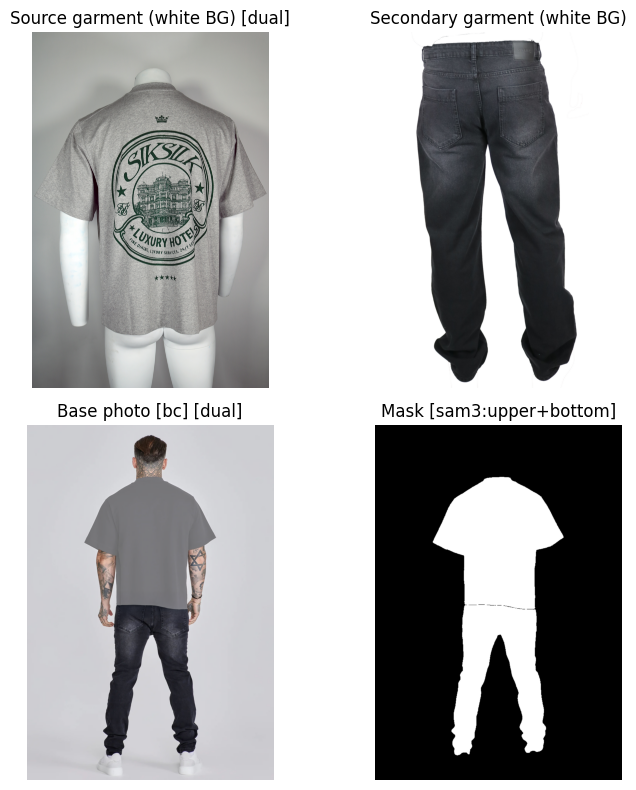

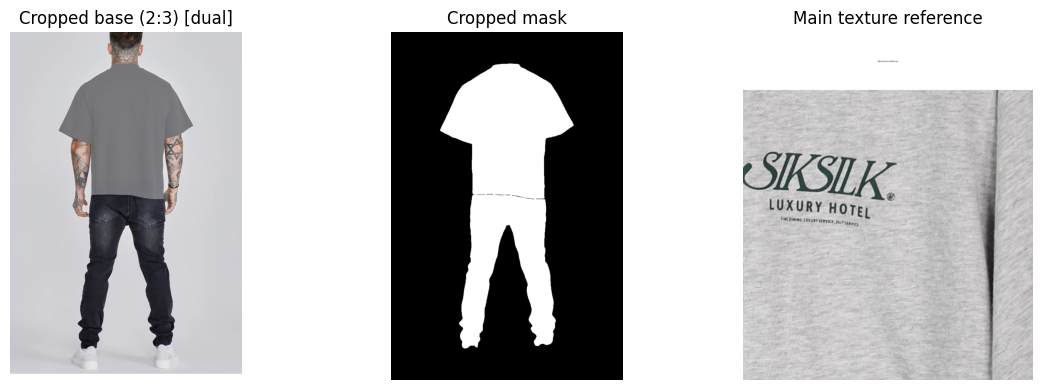

🍌 started...
      ⚠️ Generator returned image (3392, 5056); resizing to (2354, 3530).


/tmp/ipython-input-181548975.py:84: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_img = Image.fromarray(alpha, mode="L")


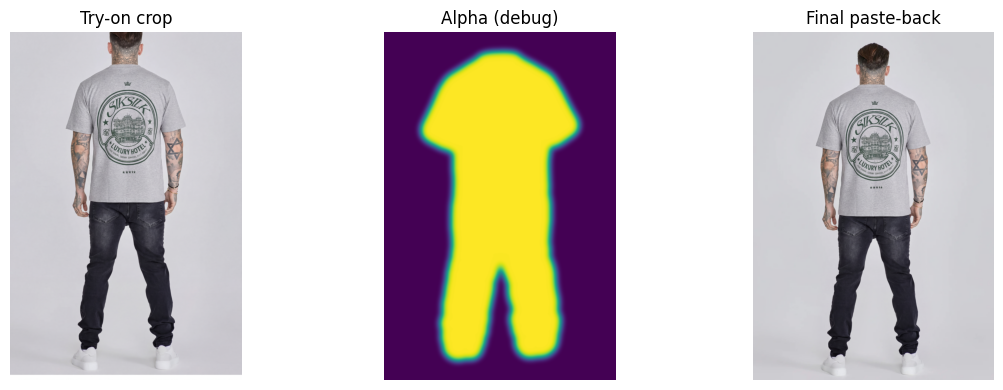

      ✅ Uploaded [dual] → dazzl:Dazzl/SikSilk/SS_OUTPUT_FOLDER/rclone/SS-29007-bc_both.png
     2/4    fr.JPG  | USING STRICT base/mask='fr'
Segmentation started for fr.png [upper garment] via fal.ai SAM3
Segmentation started for fr.png [bottom garment] via fal.ai SAM3


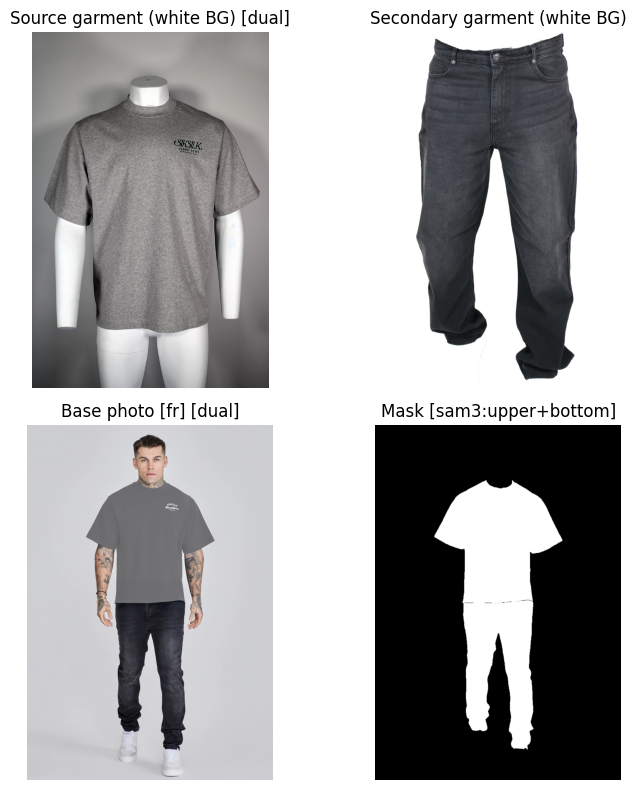

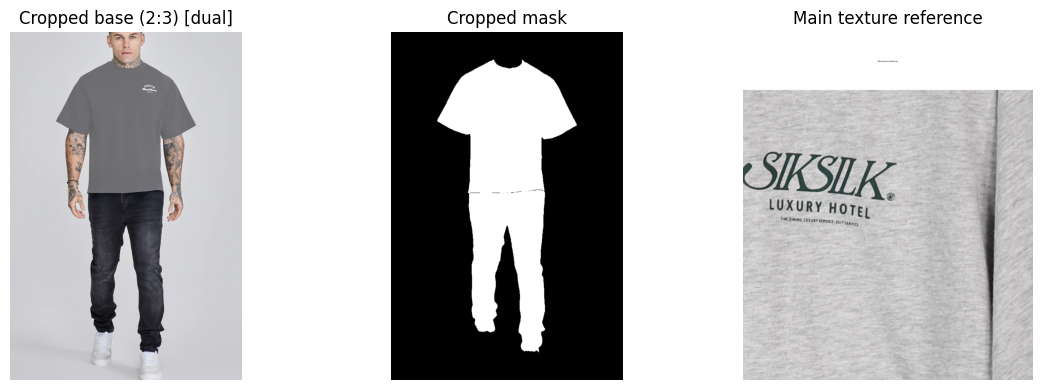

🍌 started...
      ⚠️ Generator returned image (3392, 5056); resizing to (2685, 4027).


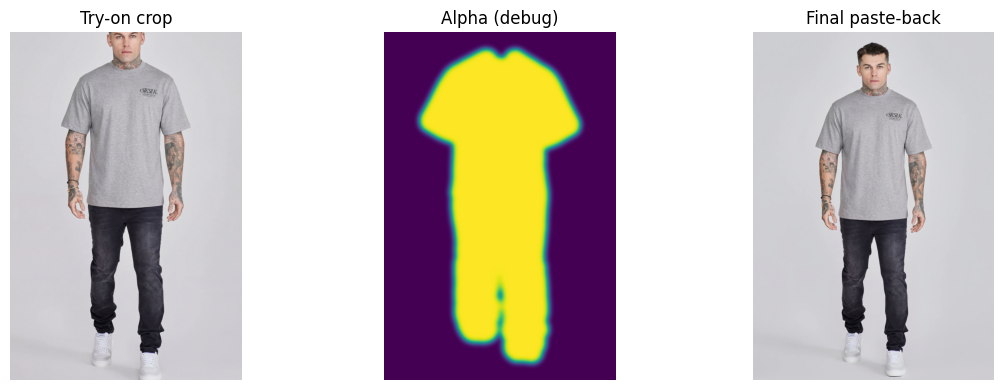

      ✅ Uploaded [dual] → dazzl:Dazzl/SikSilk/SS_OUTPUT_FOLDER/rclone/SS-29007-fr_both.png
     3/4    fr_cut.png  | USING STRICT base/mask='fr_cl'
Segmentation started for fr_cl.png [upper garment] via fal.ai SAM3
Segmentation started for fr_cl.png [bottom garment] via fal.ai SAM3


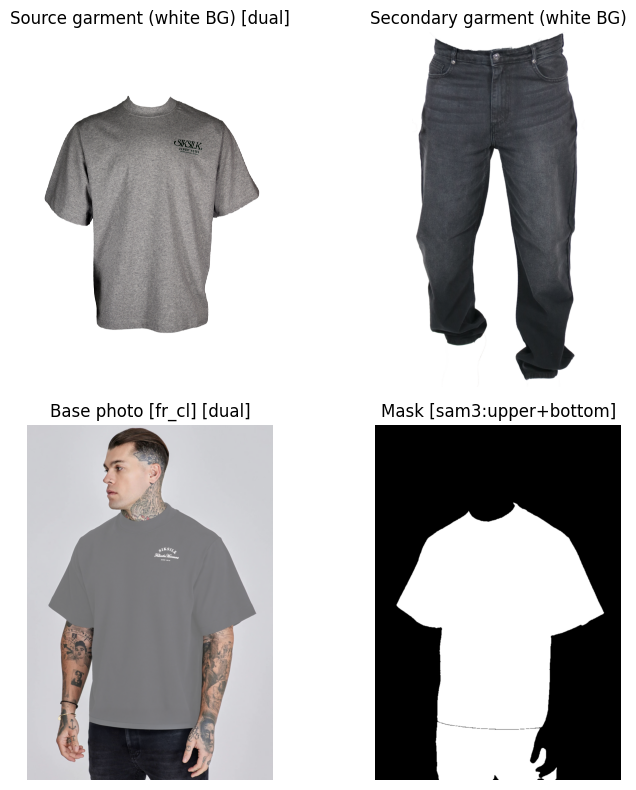

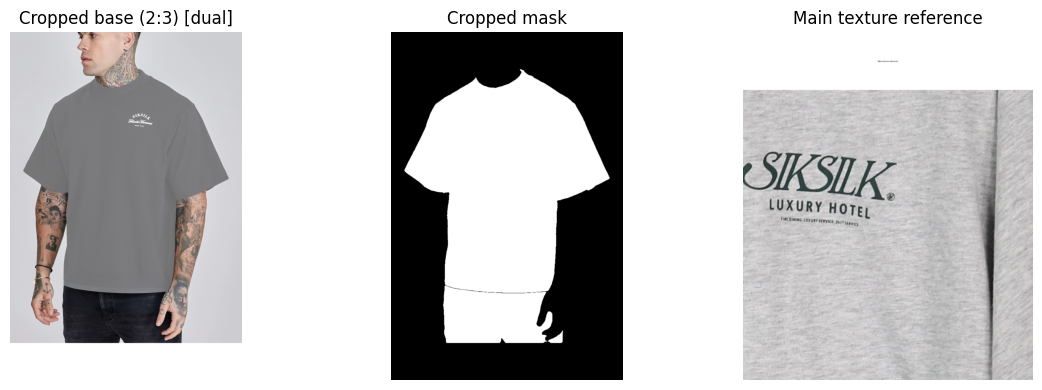

🍌 started...
      ⚠️ Generator returned image (3392, 5056); resizing to (2954, 4431).


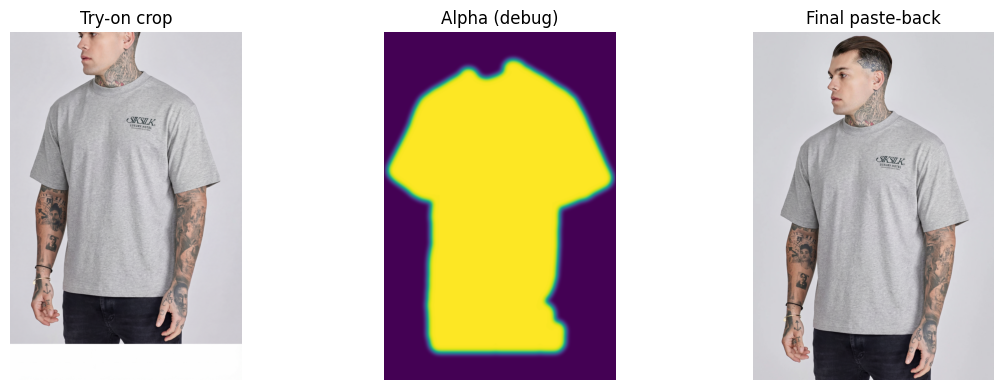

      ✅ Uploaded [dual] → dazzl:Dazzl/SikSilk/SS_OUTPUT_FOLDER/rclone/SS-29007-fr_cl_both.png
     4/4    fr_lft.JPG  | USING STRICT base/mask='fr_lft'
Segmentation started for fr_lft.png [upper garment] via fal.ai SAM3
Segmentation started for fr_lft.png [bottom garment] via fal.ai SAM3


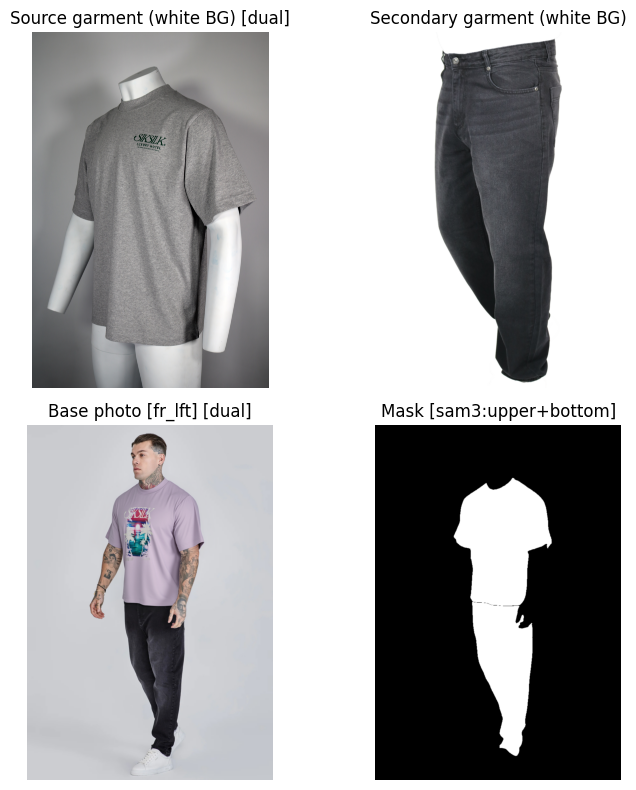

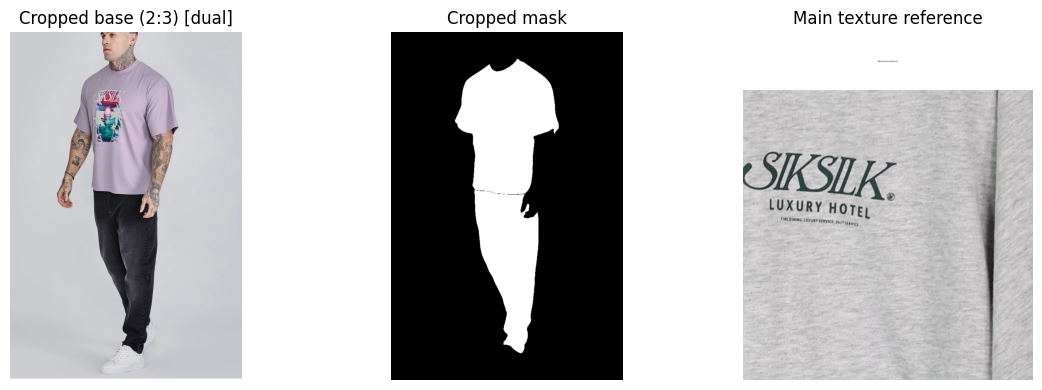

🍌 started...
      ⚠️ Generator returned image (3392, 5056); resizing to (2757, 4135).


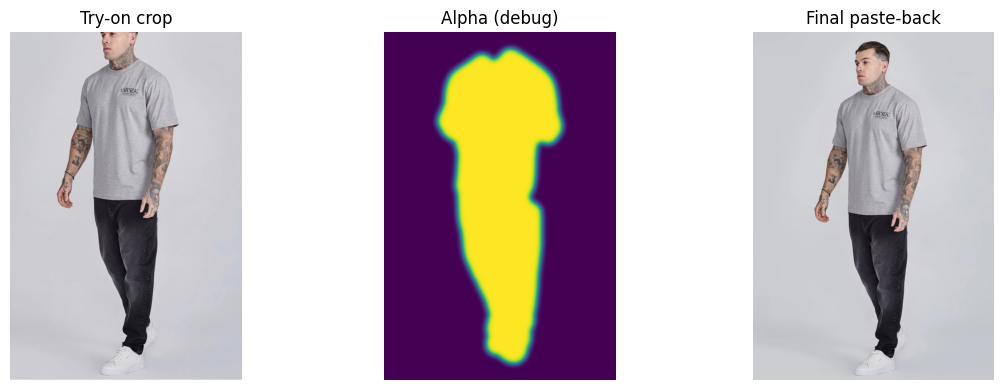

      ✅ Uploaded [dual] → dazzl:Dazzl/SikSilk/SS_OUTPUT_FOLDER/rclone/SS-29007-fr_lft_both.png
✅ Finished: SS-29007

🏁 List run complete.


In [39]:
# Dispatch
run_list()


#UNASSIGN

In [ ]:
from google.colab import runtime
runtime.unassign()